In [145]:
import joblib as jb
import pandas as pd
import psycopg2
import sqlalchemy 
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from collections import Counter
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [320]:
params = {
    "host": "localhost",
    "user": "postgres",
    "port": 5432,
    "password": "*****" 
}
connection = psycopg2.connect(**params, dbname= "postgres")

In [321]:
df=pd.read_sql('select * from public.customer_fraud',connection)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [147]:
#df=pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [322]:
df.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [149]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [150]:
df['type']=df['type'].map({'PAYMENT':1,'CASH_OUT':2, 'CASH_IN':3,'TRANSFER':4,'DEBIT':5})

In [151]:
df['type'].value_counts()

2    2237500
1    2151495
3    1399284
4     532909
5      41432
Name: type, dtype: int64

In [152]:
df.isFraud.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [153]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 534.0+ MB


In [155]:
df=df.loc[0:20000,('type','amount','oldbalanceOrg','newbalanceOrig','isFraud')] #sayısal feature lar ile devam edelim.

In [156]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,1,9839.64,170136.0,160296.36,0
1,1,1864.28,21249.0,19384.72,0
2,4,181.00,181.0,0.00,1
3,2,181.00,181.0,0.00,1
4,1,11668.14,41554.0,29885.86,0


In [157]:
df.isFraud.value_counts(normalize=True)

0    0.99595
1    0.00405
Name: isFraud, dtype: float64

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            20001 non-null  int64  
 1   amount          20001 non-null  float64
 2   oldbalanceOrg   20001 non-null  float64
 3   newbalanceOrig  20001 non-null  float64
 4   isFraud         20001 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


In [159]:
X=df.loc[0:20000,('type','amount','oldbalanceOrg','newbalanceOrig')]

In [160]:
y=df['isFraud']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42, stratify=y)

In [162]:
X_train.shape

(16000, 4)

In [163]:
y_test.shape

(4001,)

In [164]:
##featutureları standart hale getirelim
std_scale = StandardScaler()
X_train_transformed = std_scale.fit_transform(X_train) 
X_test_transformed = std_scale.transform(X_test) 

lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_transformed, y_train)

print('LogReg Training Score: {:6.2f}%'.format(100*lm1.score(X_train_transformed, y_train)))
print('LogReg Test Score: {:6.2f}%'.format(100*lm1.score(X_test_transformed, y_test)))

LogReg Training Score:  99.62%
LogReg Test Score:  99.60%


In [165]:
from sklearn.model_selection import cross_val_score
lm1 = LogisticRegression(solver='liblinear')
scores = cross_val_score(lm1, X_test_transformed, y_test, cv=10, scoring='accuracy') # Veri setini 10 farklı formatta hazırla
print(scores)

[0.995 0.998 0.998 0.998 0.998 0.995 0.995 0.995 0.995 0.995]


In [166]:
scores.mean()

0.9960012468827928

In [167]:
np.set_printoptions(suppress=True, precision=3) # Üretilen çıktıyı istenilen formata getirme
lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_transformed, y_train)
lm1.predict_proba(X_test_transformed[:5,]) 

array([[0.996, 0.004],
       [0.996, 0.004],
       [0.998, 0.002],
       [0.996, 0.004],
       [0.998, 0.002]])

In [168]:
lm1.predict(X_test_transformed[:5,]) 

array([0, 0, 0, 0, 0], dtype=int64)

In [169]:
print('Logistic Regression Confusion Matrix: \n\n', confusion_matrix(y_test, lm1.predict(X_test_transformed)))

Logistic Regression Confusion Matrix: 

 [[3985    0]
 [  16    0]]


In [170]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [171]:
y_pred = lm1.predict(X_test_transformed)

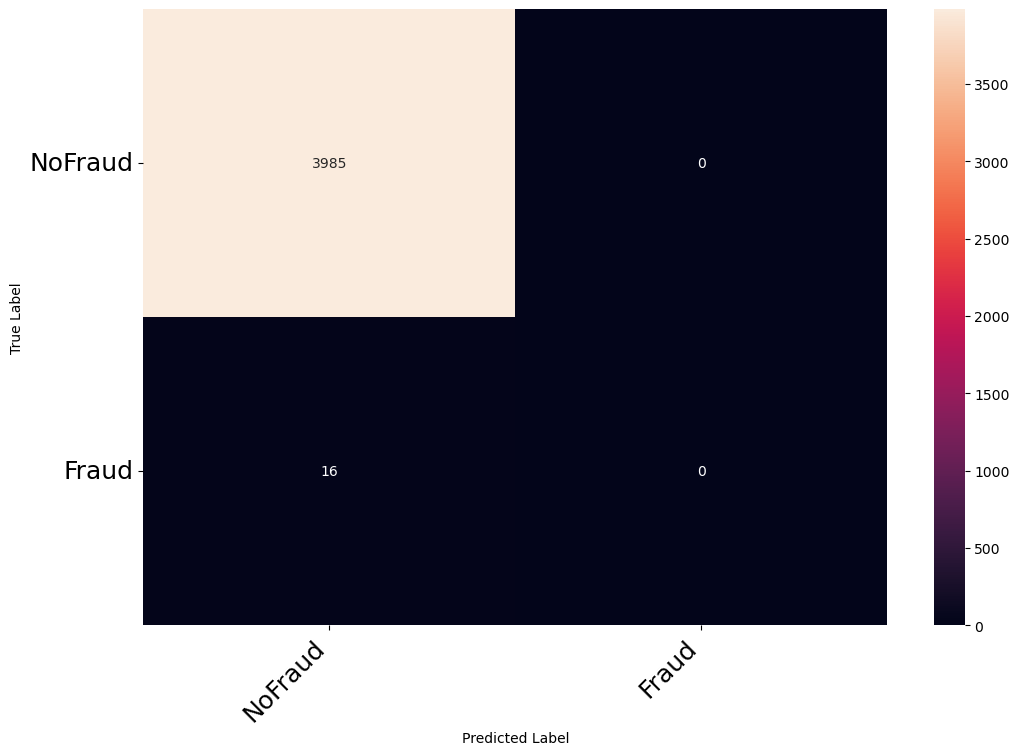

In [172]:
### logistic regresyon ile kurdugumuz modelimizin genel başarısı baya iyi olsa da azınlık sınıfı dogru tahmın etmekte cok zorlanıyor
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [173]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [174]:
evaluate_model(lm1, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.996,1.0,0.996,0.998,0.5


In [175]:
evaluate_model(lm1, X_test_transformed, y_test, pred_label=1)  ##class 1 için f1 score ne kadar düşük!!!

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.996,0.0,0.0,0.0,0.5


In [176]:
## random oversampling

In [177]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [178]:
Counter(y_resampled)

Counter({0: 15935, 1: 15935})

In [179]:
svc_ros = SVC(probability=True).fit(X_resampled, y_resampled)

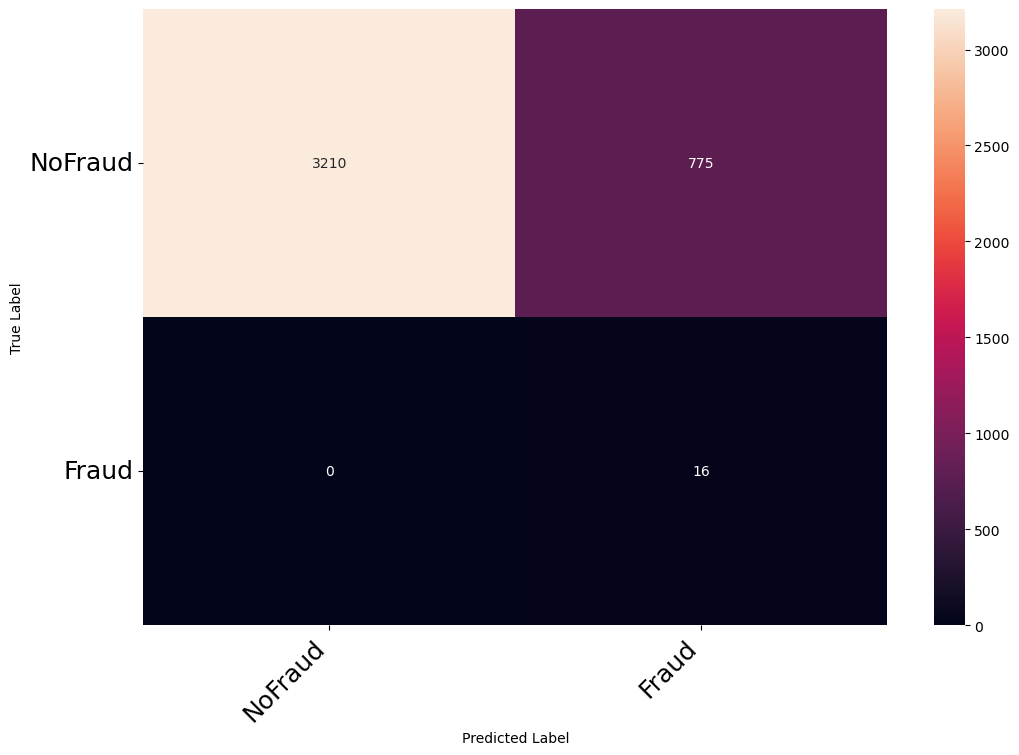

In [180]:
print_confusion_matrix(confusion_matrix(y_test, svc_ros.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [181]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.806,0.806,1.0,0.892,0.903


In [182]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.806,1.0,0.02,0.04,0.903


In [183]:
#smoote

In [184]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train_transformed, y_train)
Counter(y_smoted)

Counter({0: 15935, 1: 15935})

In [185]:
svc_smote = SVC(probability=True).fit(X_smoted, y_smoted)

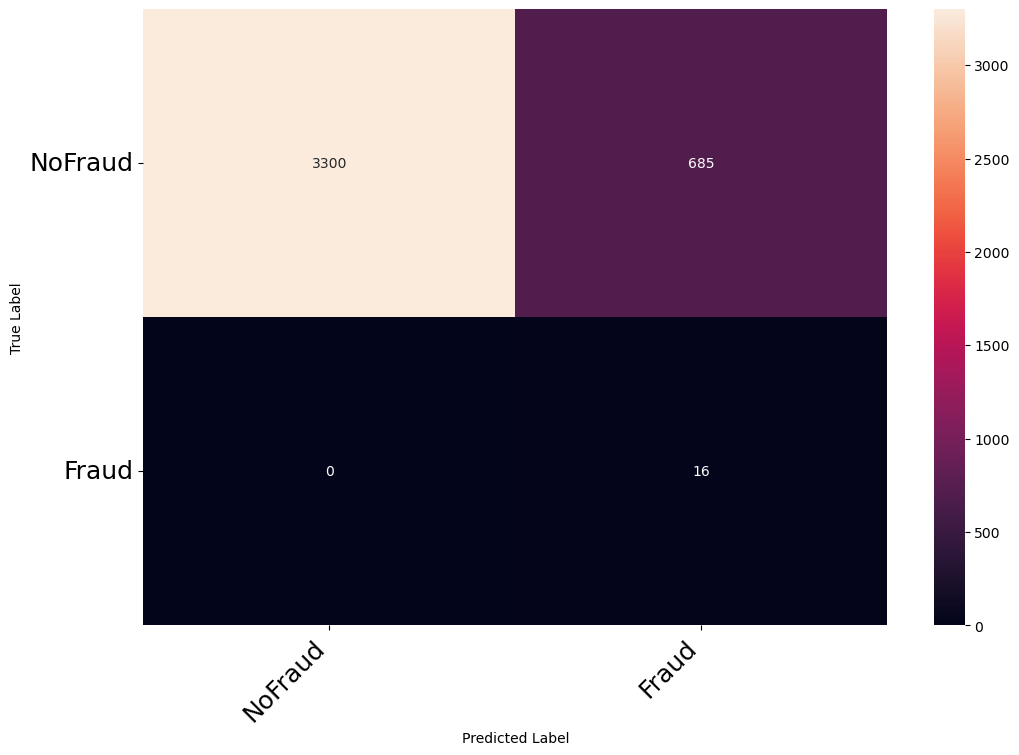

In [186]:
print_confusion_matrix(confusion_matrix(y_test, svc_smote.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [187]:
evaluate_model(svc_smote, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.829,0.828,1.0,0.906,0.914


In [188]:
evaluate_model(svc_smote, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.829,1.0,0.023,0.045,0.914


In [189]:
## adasyn

In [190]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_transformed, y_train)
Counter(y_adasyn)

Counter({0: 15935, 1: 15940})

In [191]:
svc_adasyn = SVC(probability=True).fit(X_adasyn, y_adasyn)

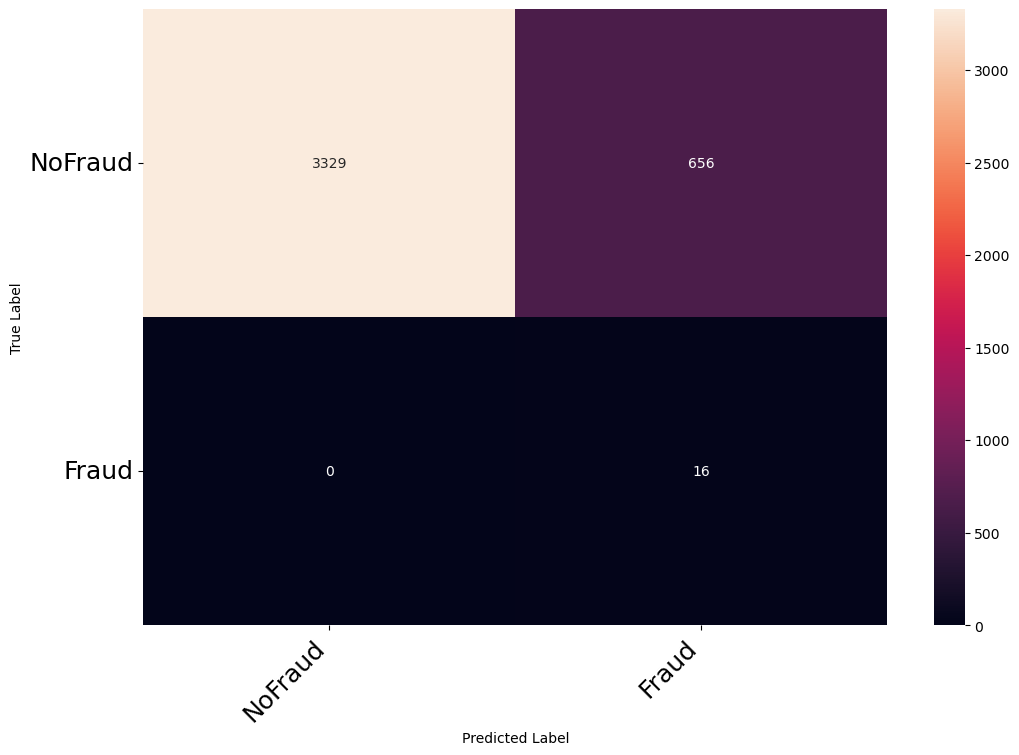

In [192]:
print_confusion_matrix(confusion_matrix(y_test, svc_adasyn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [193]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.836,0.835,1.0,0.91,0.918


In [194]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.836,1.0,0.024,0.047,0.918


In [195]:
##borderline smoot

In [196]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train_transformed, y_train)
Counter(y_blsmote)

Counter({0: 15935, 1: 15935})

In [197]:
svc_blsmote = SVC(probability=True).fit(X_blsmote, y_blsmote)

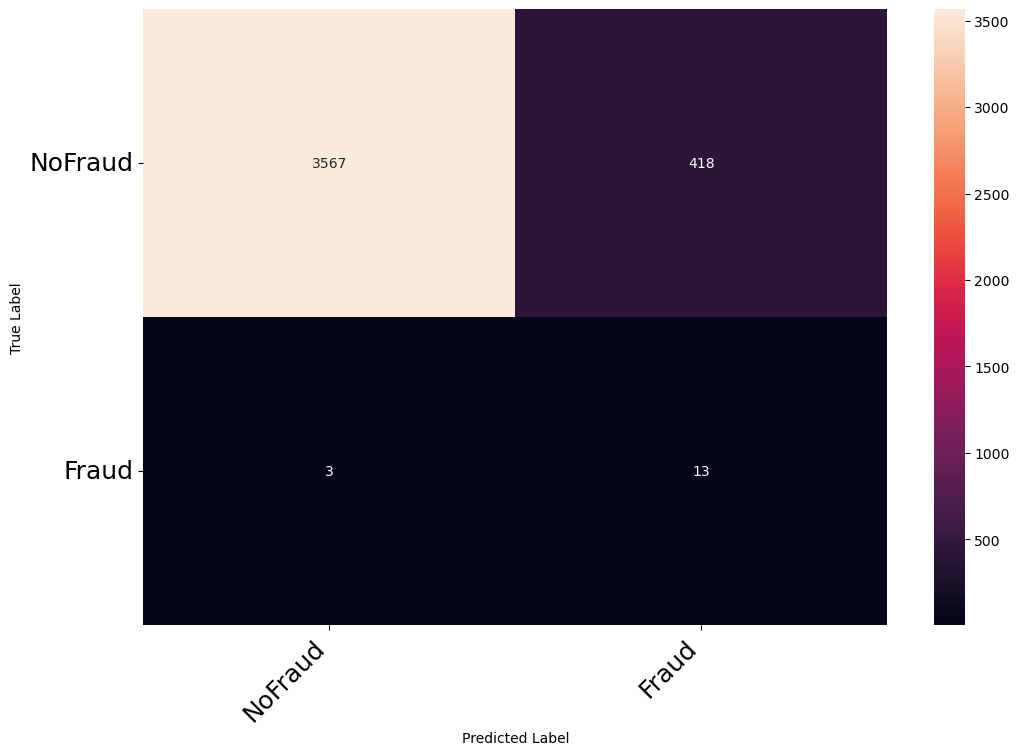

In [198]:
print_confusion_matrix(confusion_matrix(y_test, svc_blsmote.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [199]:
evaluate_model(svc_blsmote, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.895,0.895,0.999,0.944,0.854


In [200]:
evaluate_model(svc_blsmote, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.895,0.812,0.03,0.058,0.854


In [201]:
### random oversampling işlemini SVC dışında bir model ile denedim.

In [202]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [203]:
lm2 = LogisticRegression().fit(X_resampled, y_resampled)

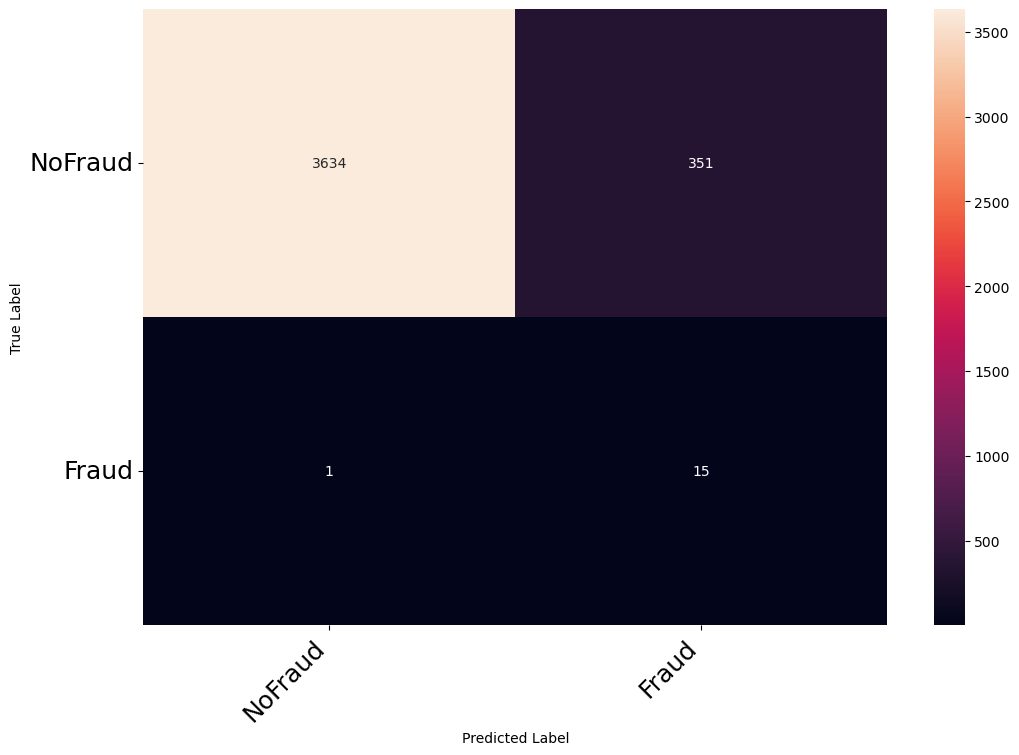

In [204]:
print_confusion_matrix(confusion_matrix(y_test, lm2.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [205]:
evaluate_model(lm2, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.912,0.912,1.0,0.954,0.925


In [206]:
evaluate_model(lm2, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.912,0.938,0.041,0.079,0.925


In [207]:
### cok buyuk veri ile çalışmadıgımız ıcın undersampling denemedim

In [208]:
###########################################################################################################################

In [209]:
#KNN ile model oluşturma  ##################################

In [210]:

knn1 = KNeighborsClassifier()
knn1.fit(X_train_transformed, y_train)

print('knn Training Score: {:6.2f}%'.format(100*knn1.score(X_train_transformed, y_train)))
print('knn Test Score: {:6.2f}%'.format(100*knn1.score(X_test_transformed, y_test)))

knn Training Score:  99.71%
knn Test Score:  99.60%


In [211]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_test_transformed, y_test, cv=10, scoring='accuracy') # Veri setini 10 farklı formatta hazırla
print(scores)

[0.995 0.998 0.998 0.998 0.998 0.995 0.995 0.995 0.995 0.995]


In [212]:
scores.mean()

0.9960012468827928

In [213]:
##knn modeli için en iyi parametleri seçme  ## GRIDSEARCH

In [214]:
from sklearn.model_selection import GridSearchCV

In [215]:
# GridSearchCV'nin bakacağı k parametrelerini seçiyoruz
# Hangi parametrelerin değerlendirileceğini tanımlama
k_range = list(range(1, 40))
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']


In [216]:
# Dictionary yapısını tekrardan kuruyoruz
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}


In [217]:
# GridSearchCV'yi tanımlıyoruz
grid1 = GridSearchCV(knn1, param_grid, cv=5, scoring='accuracy')
grid1.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [218]:
print('Best Score:', grid1.best_score_, 'Best Parameters:', grid1.best_params_)

Best Score: 0.9969999999999999 Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [219]:
knn1 = KNeighborsClassifier( n_neighbors=9,metric='manhattan',weights='distance')
knn1.fit(X_train_transformed, y_train)

print('KNN Training Score: {:6.2f}%'.format(100*knn1.score(X_train_transformed, y_train)))
print('KNN  Test Score: {:6.2f}%'.format(100*knn1.score(X_test_transformed, y_test)))

KNN Training Score: 100.00%
KNN  Test Score:  99.70%


In [220]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [221]:
y_pred = knn1.predict(X_test_transformed)

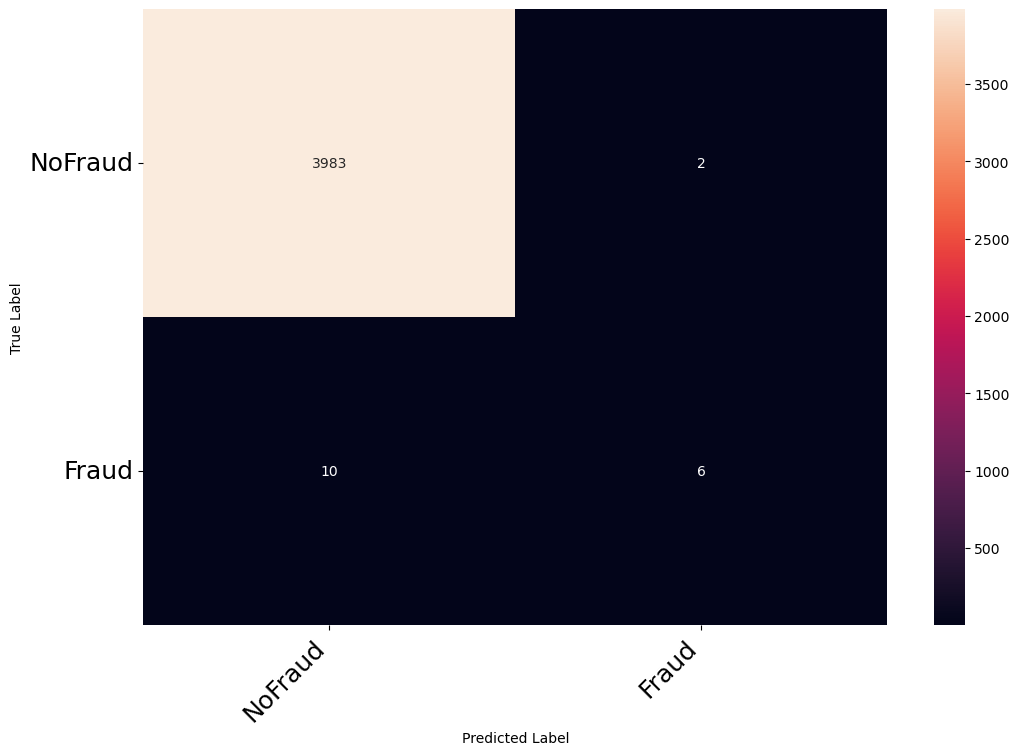

In [222]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [223]:
evaluate_model(knn1, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.997,0.999,0.997,0.998,0.687


In [224]:
evaluate_model(knn1, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.997,0.375,0.75,0.5,0.687


In [225]:
#smote

In [226]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train_transformed, y_train)

In [227]:
knn = KNeighborsClassifier().fit(X_smoted, y_smoted)

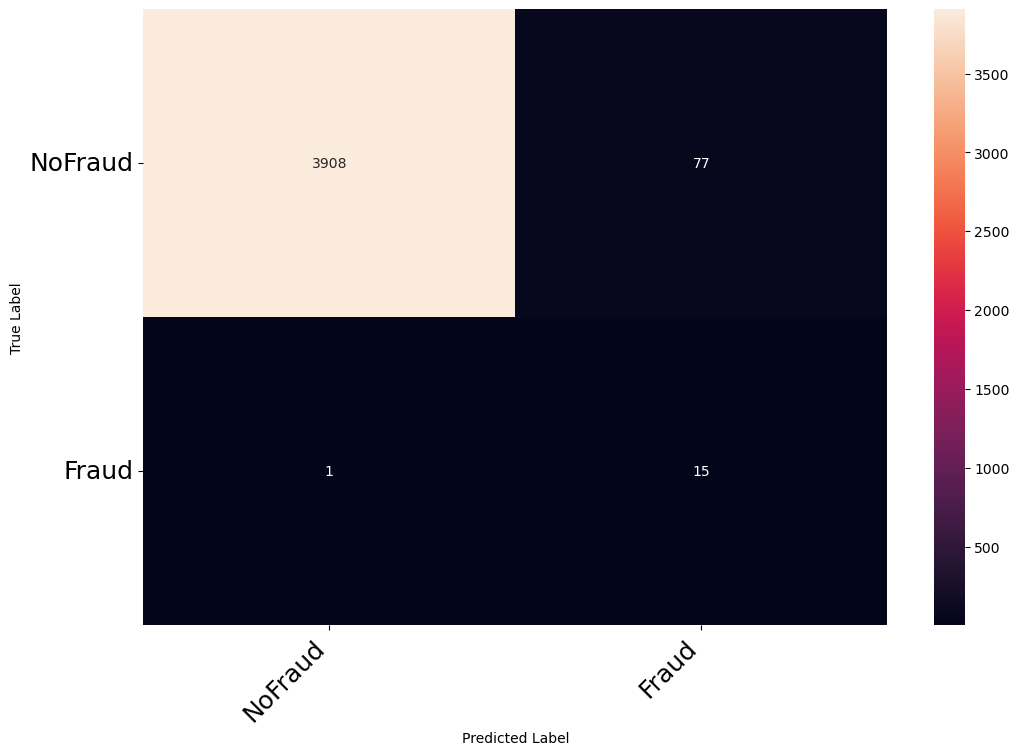

In [228]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [229]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.981,0.981,1.0,0.99,0.959


In [230]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.981,0.938,0.163,0.278,0.959


In [231]:
#ADSYN

In [232]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_transformed, y_train)

In [233]:
knn = KNeighborsClassifier().fit(X_adasyn, y_adasyn)

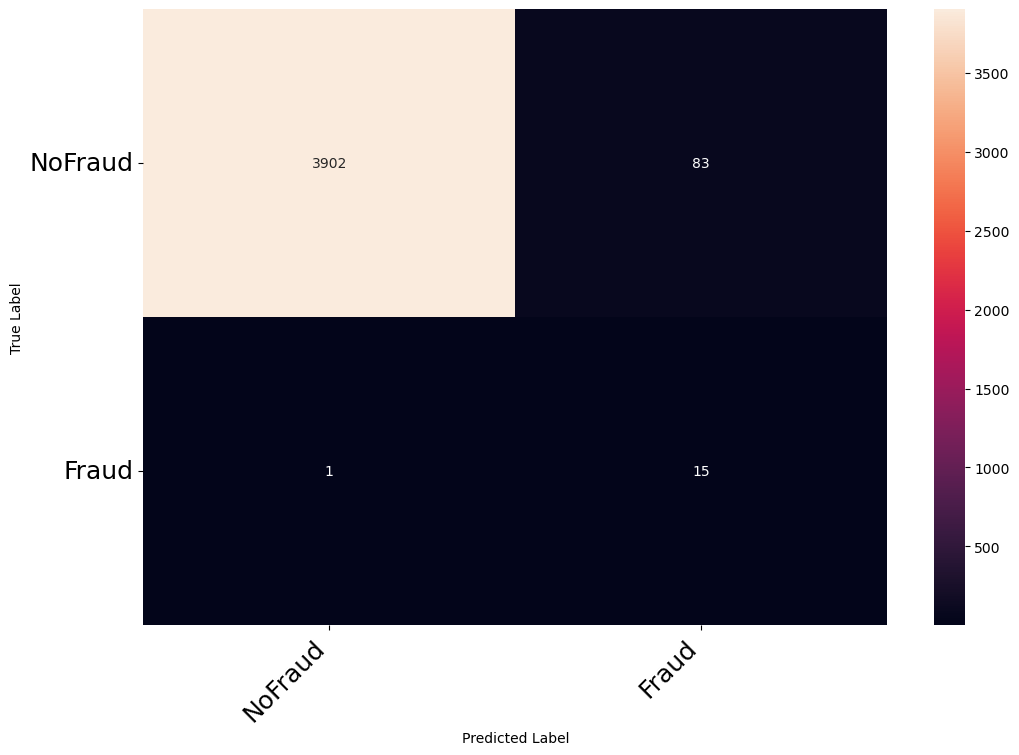

In [234]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [235]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.979,0.979,1.0,0.989,0.958


In [236]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.979,0.938,0.153,0.263,0.958


In [237]:
##borderline smote

In [238]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train_transformed, y_train)

In [239]:
knn = KNeighborsClassifier().fit(X_blsmote, y_blsmote)

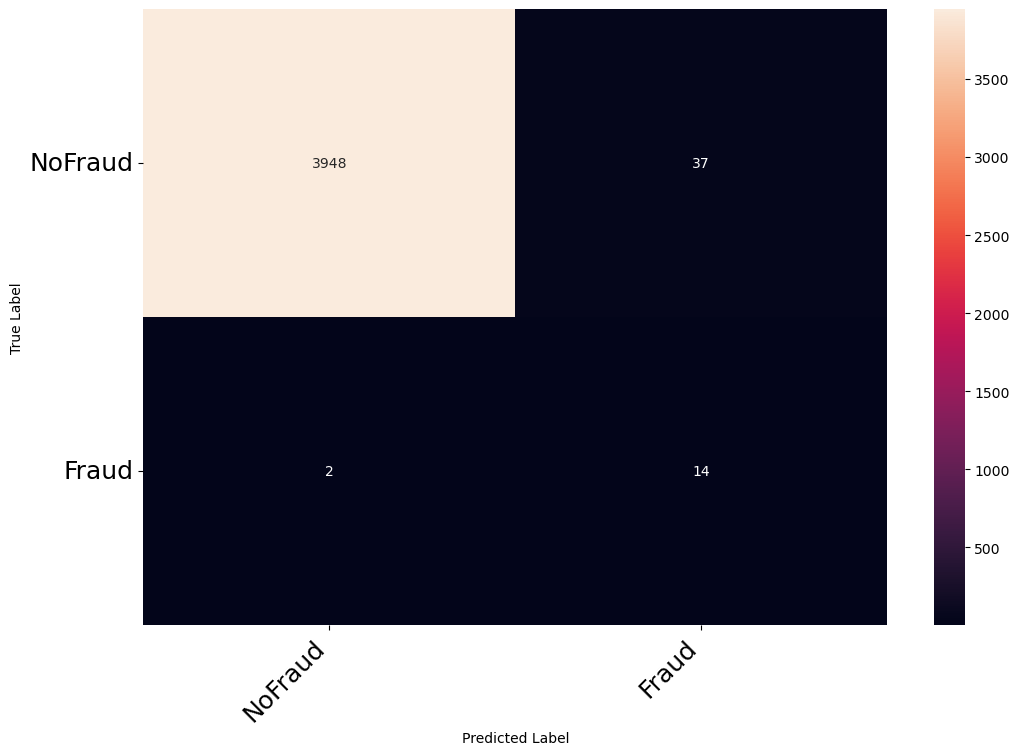

In [240]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [241]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.99,0.991,0.999,0.995,0.933


In [242]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.99,0.875,0.275,0.418,0.933


In [243]:
############### ağaç algolarına geçelim

In [244]:
### decısıon tree model

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42, stratify=y)

In [246]:
dt_model=DecisionTreeClassifier().fit(X_train,y_train)

In [247]:
y_pred_dt=dt_model.predict(X_test)

In [248]:
confusion_matrix(y_test, y_pred_dt)

array([[3981,    4],
       [   3,   13]], dtype=int64)

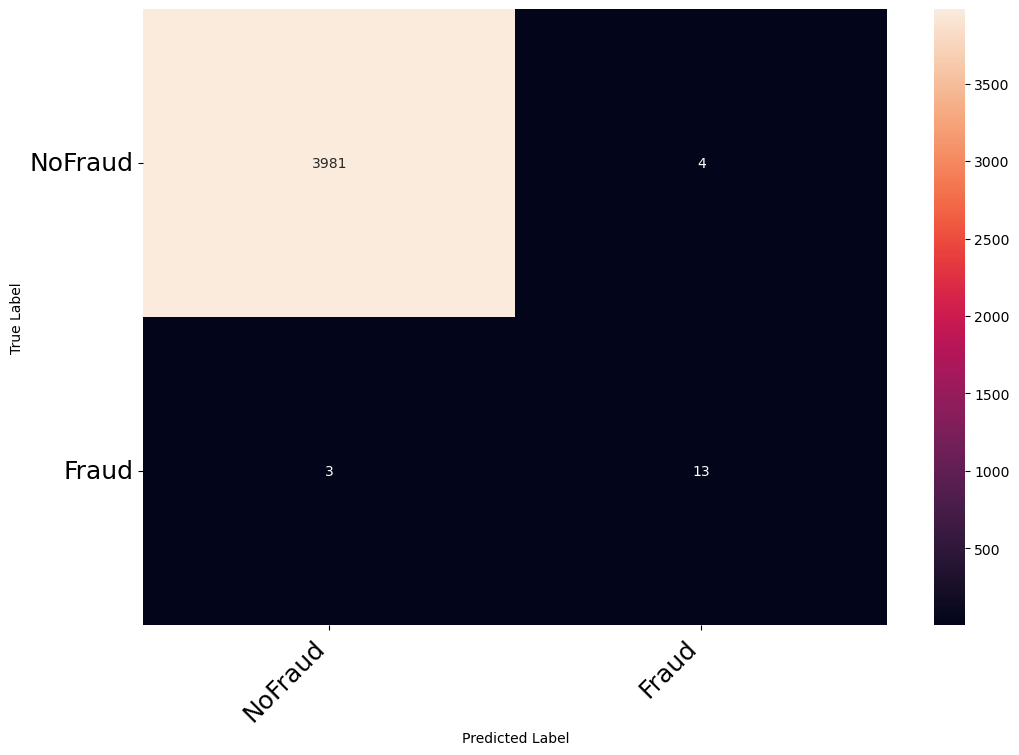

In [249]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [250]:
importances_dt = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dt_model.feature_importances_,3)})
importances_dt = importances_dt.sort_values('Importance', ascending=False).set_index('Feature')
importances_dt

,Importance
Feature,
amount,0.459
oldbalanceOrg,0.391
type,0.146
newbalanceOrig,0.004


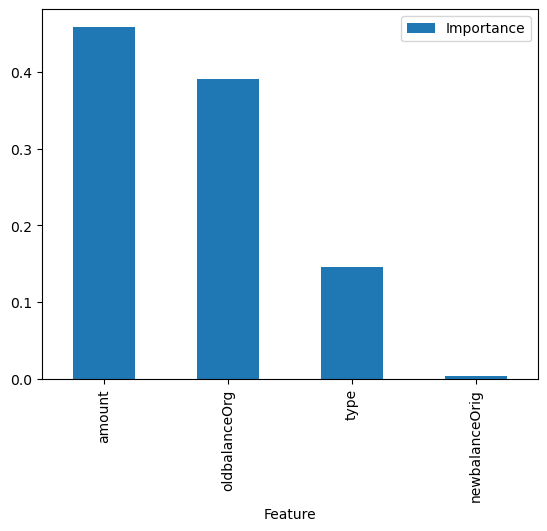

In [251]:
importances_dt.plot.bar();    ## modeldeki featurelarımızın önem dereceleleri
## her modeli tüm featurelar üzerinden kurup sonrasında en başarılı model üzerinden feature ekleme ve cıkarma işelmleri 
## yapmayı planladım

In [252]:
evaluate_model(dt_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,0.999,0.999,0.999,0.906


In [253]:
evaluate_model(dt_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.812,0.765,0.788,0.906


In [254]:
### random forest model

In [255]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [256]:
y_pred_rf = rf_model.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[3982,    3],
       [   7,    9]], dtype=int64)

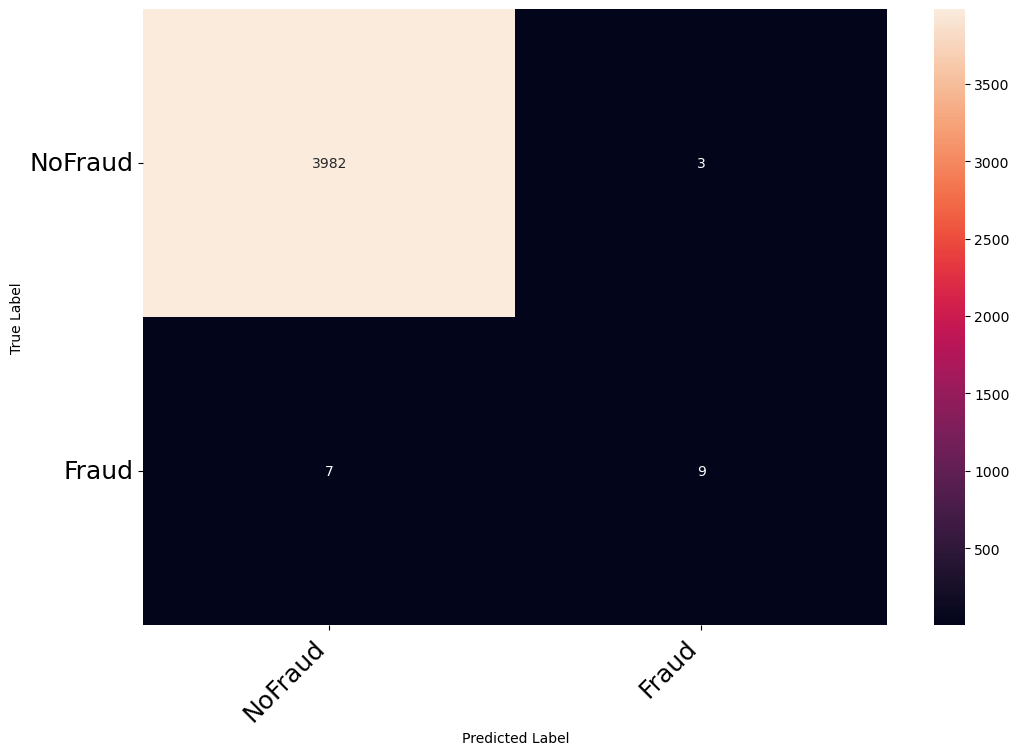

In [257]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [258]:
importances_rf = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_rf = importances_rf.sort_values('Importance', ascending=False).set_index('Feature')
importances_rf

,Importance
Feature,
amount,0.511
oldbalanceOrg,0.428
type,0.039
newbalanceOrig,0.022


In [259]:
evaluate_model(rf_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,0.999,0.998,0.999,0.781


In [260]:
evaluate_model(rf_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.562,0.75,0.643,0.781


In [261]:
###xgboost model

In [262]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [263]:
y_pred_xgb = xgb_model.predict(X_test)
confusion_matrix(y_test, y_pred_xgb)

array([[3984,    1],
       [   3,   13]], dtype=int64)

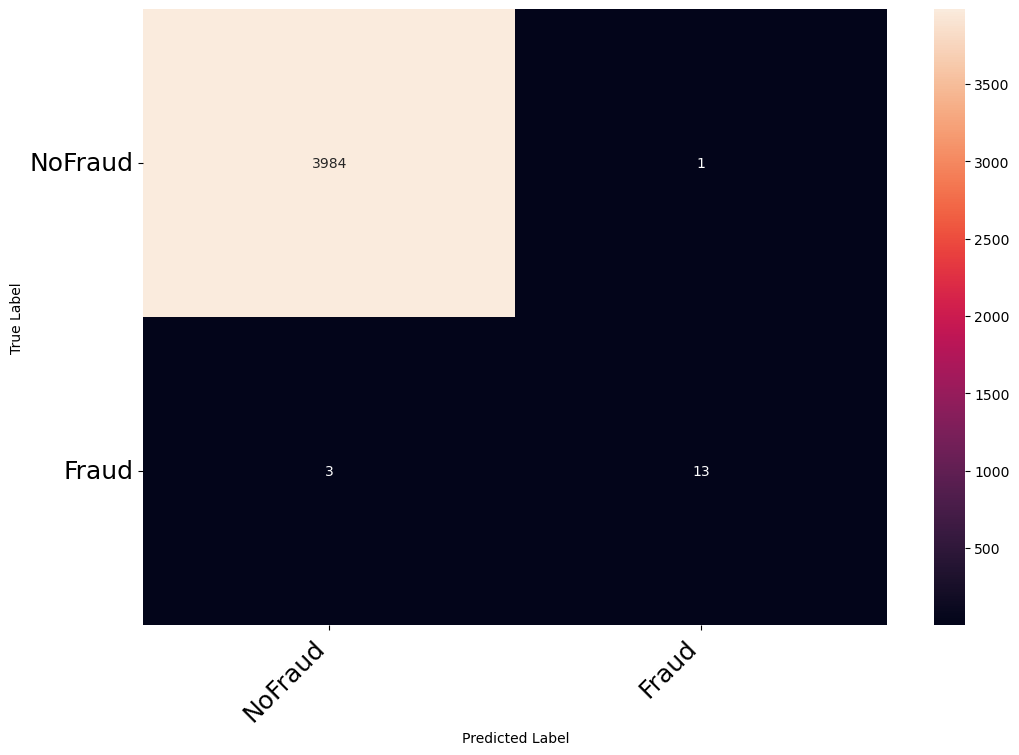

In [264]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [265]:
importances_xgb = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_xgb = importances_xgb.sort_values('Importance', ascending=False).set_index('Feature')
importances_xgb

,Importance
Feature,
amount,0.511
oldbalanceOrg,0.428
type,0.039
newbalanceOrig,0.022


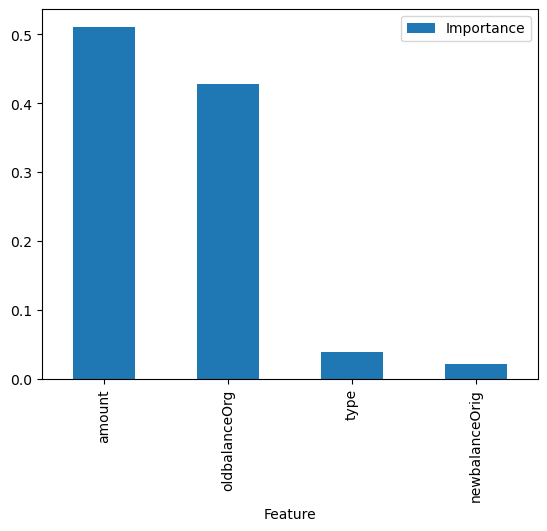

In [266]:
importances_xgb.plot.bar();

In [267]:
evaluate_model(xgb_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.999,1.0,0.999,0.999,0.906


In [268]:
evaluate_model(xgb_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.999,0.812,0.929,0.867,0.906


In [269]:
### ağaçlar içinden xgboost ile devam edelim

In [270]:
## random over sampling yapalım

In [271]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [272]:
xgb_ros = XGBClassifier().fit(X_resampled, y_resampled)

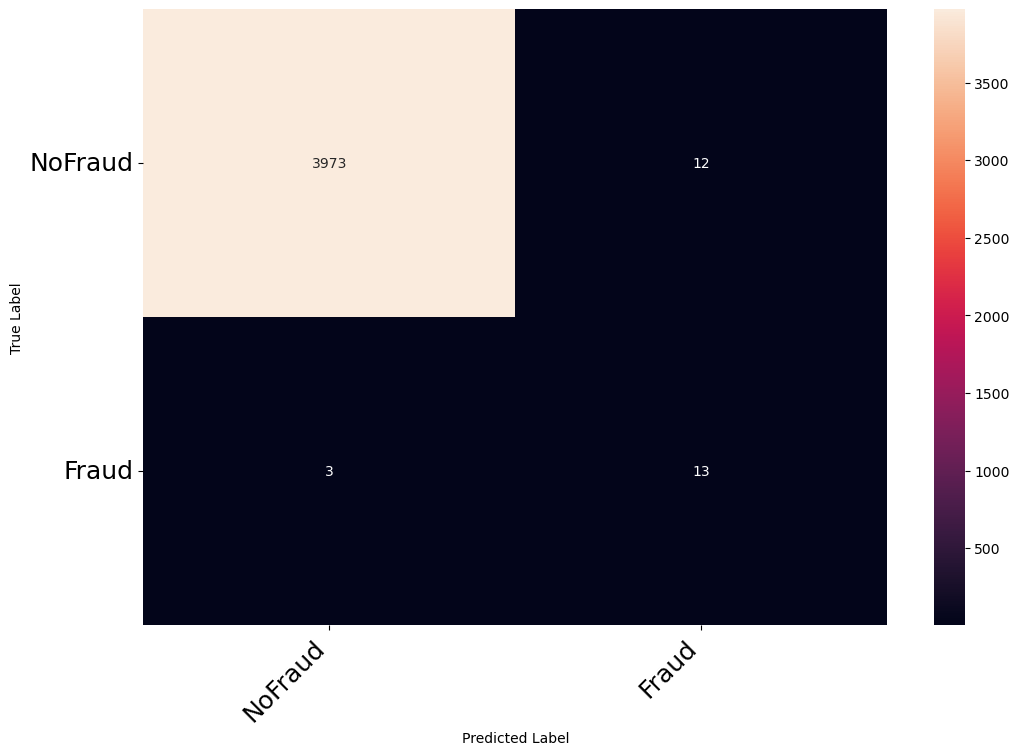

In [273]:
print_confusion_matrix(confusion_matrix(y_test, xgb_ros.predict(X_test)), ['NoFraud', 'Fraud'])

In [274]:
evaluate_model(xgb_ros, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.996,0.997,0.999,0.998,0.905


In [275]:
evaluate_model(xgb_ros, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.996,0.812,0.52,0.634,0.905


In [276]:
##smote 

In [277]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train, y_train)

In [278]:
xgb_smote = XGBClassifier().fit(X_smoted, y_smoted)

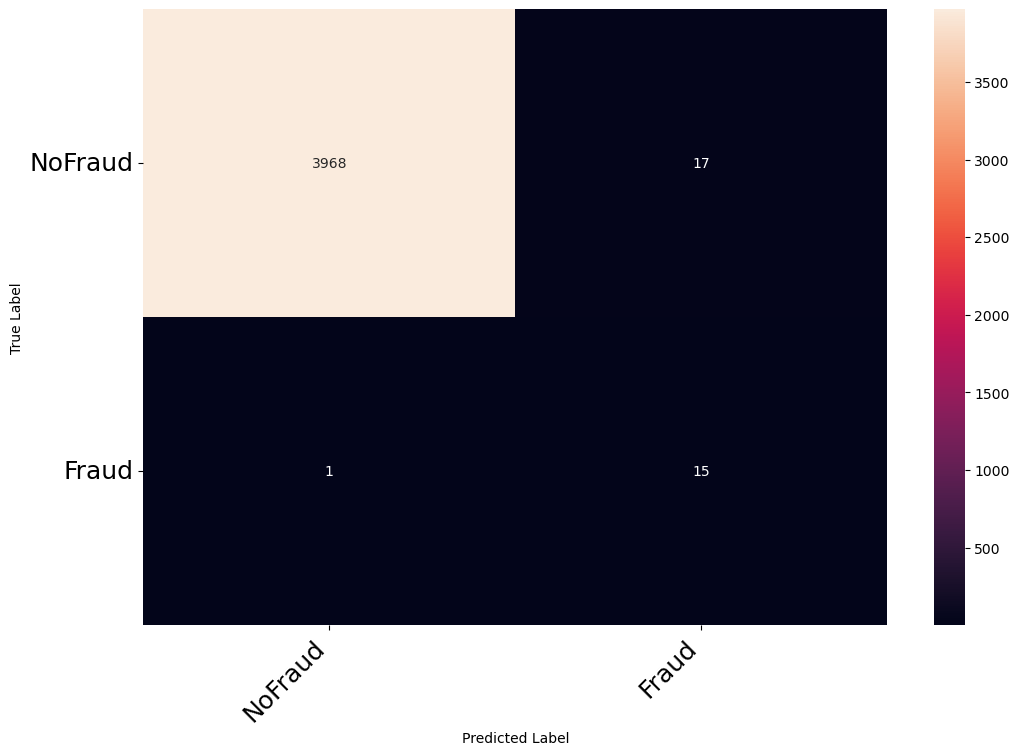

In [279]:
print_confusion_matrix(confusion_matrix(y_test, xgb_smote.predict(X_test)), ['NoFraud', 'Fraud'])

In [280]:
evaluate_model(xgb_smote, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.996,0.996,1.0,0.998,0.967


In [281]:
evaluate_model(xgb_smote, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.996,0.938,0.469,0.625,0.967


In [282]:
#ADASYN

In [283]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

In [284]:
xgb_adasyn = XGBClassifier().fit(X_adasyn, y_adasyn)

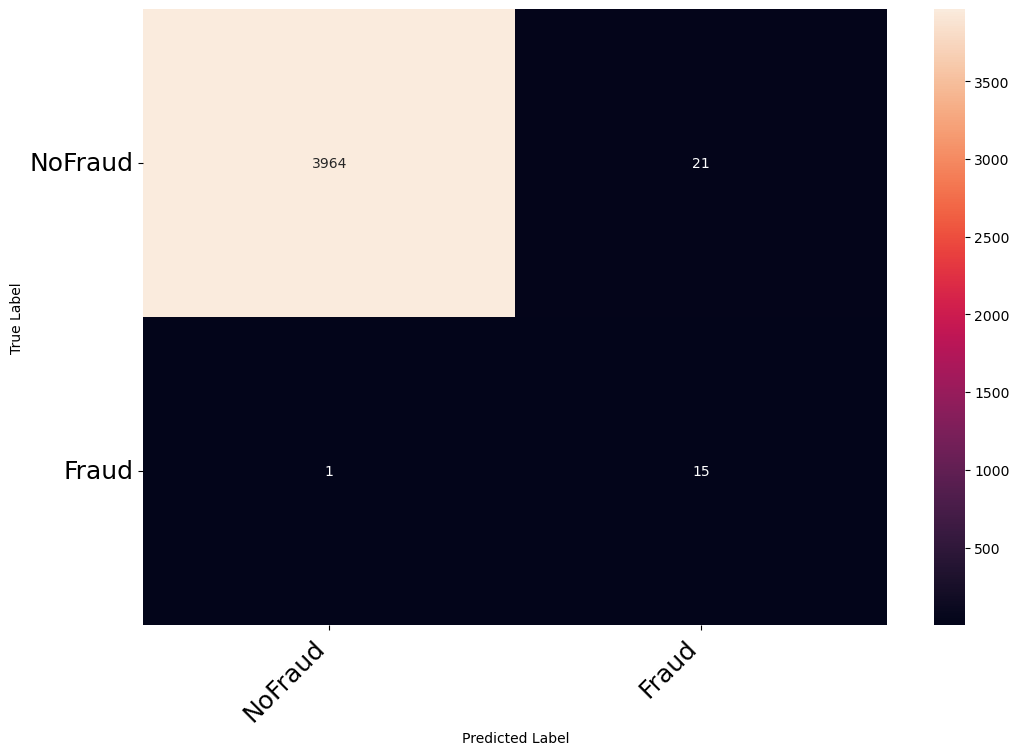

In [285]:
print_confusion_matrix(confusion_matrix(y_test, xgb_adasyn.predict(X_test)), ['NoFraud', 'Fraud'])

In [286]:
evaluate_model(xgb_adasyn, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.995,0.995,1.0,0.997,0.966


In [287]:
evaluate_model(xgb_adasyn, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.995,0.938,0.417,0.577,0.966


In [288]:
##blsmote

In [289]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)

In [290]:
xgb_blsmote = XGBClassifier().fit(X_blsmote, y_blsmote)

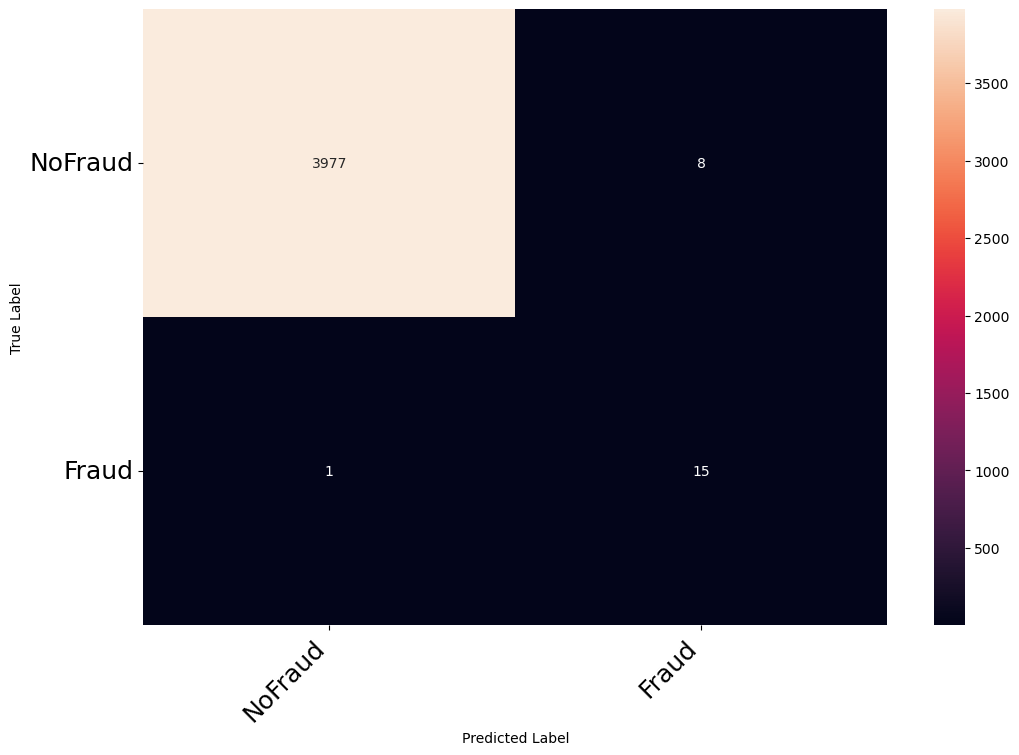

In [291]:
print_confusion_matrix(confusion_matrix(y_test, xgb_blsmote.predict(X_test)), ['NoFraud', 'Fraud'])

In [292]:
evaluate_model(xgb_blsmote, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,0.998,1.0,0.999,0.968


In [293]:
evaluate_model(xgb_blsmote, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.938,0.652,0.769,0.968


In [294]:
## en başarılı model olarak xboost un borderline smote versiyonunu kabul edelim

In [295]:
## bu model için farklı eşik degerleri ile denemeler yapalım

In [296]:
def make_confusion_matrix(model, threshold=0.50): # Ön tanımlı threshold değeri
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['NoFraud', 'Fraud'],
           yticklabels=['NoFraud', 'Fraud']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

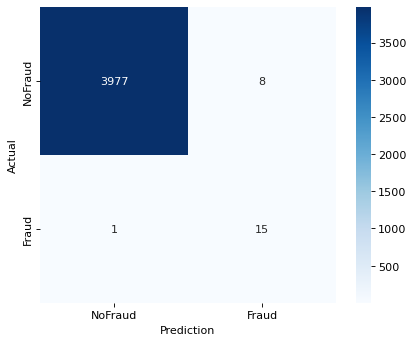

In [297]:
make_confusion_matrix(xgb_blsmote)

In [298]:
# Threshold değerini değiştirdiğimizde sonucun da interaktif bir şekilde değişmesi için bir widget

from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(xgb_blsmote, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [299]:
y_predict = xgb_blsmote.predict(X_test)
print('Default Threshold: 0.5')
print('Precision: {:6.3f},   Recall: {:6.3f}'.format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default Threshold: 0.5
Precision:  0.652,   Recall:  0.938


In [311]:
# 0.82 threshold değerine göre sınıflandırma 
new_threshold = 0.82
y_predict = (xgb_blsmote.predict_proba(X_test)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},   Recall: {:6.3f}'.format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

New Threshold: 0.1
Precision:  0.577,   Recall:  0.938


In [301]:
### SHAP

In [312]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)

In [313]:
xgb_blsmote = XGBClassifier().fit(X_blsmote, y_blsmote)

In [314]:
explainer = shap.Explainer(xgb_blsmote)
shap_values_classification = explainer(X_test)

[16:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [315]:
shap.initjs()

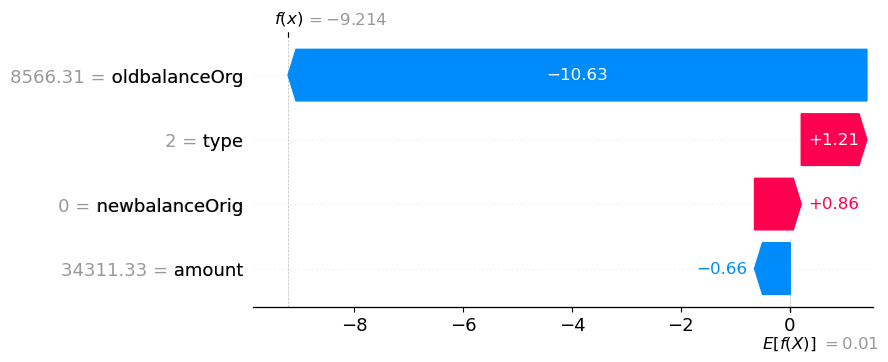

In [316]:
shap.plots.waterfall(shap_values_classification[0])

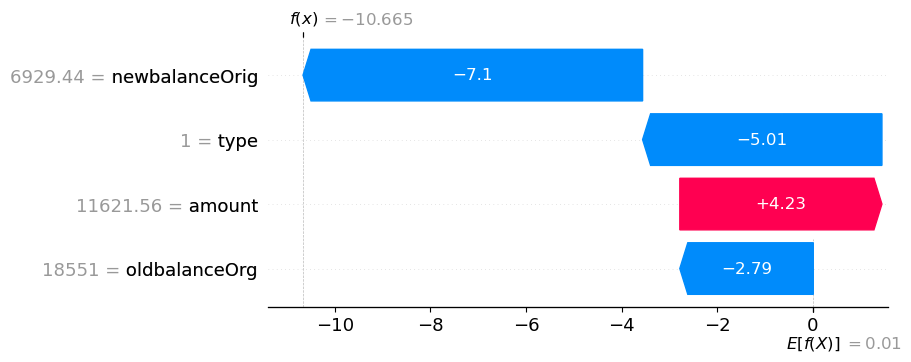

In [317]:
shap.plots.waterfall(shap_values_classification[10])

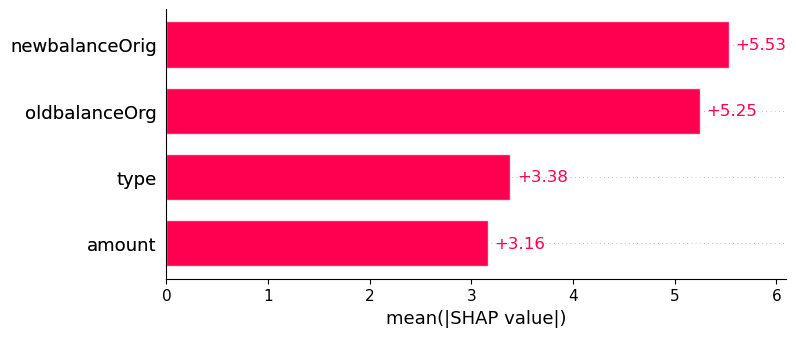

In [318]:
shap.plots.bar(shap_values_classification)

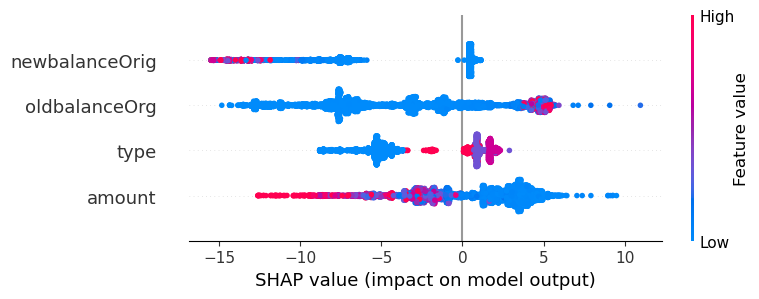

In [319]:
shap.summary_plot(shap_values_classification, X_test)